#### Lecture 14 - Parameter Estimation, Least Squares

##### C&C Problem 20.25

Find best-fit linear relationship between annual precipitation (cm) and annual streamflow (m$^3$/s). Data given in the code below. 
- Report $r^2$ value and compare to `scipy.stats.linregress` (docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html))
- Estimate annual streamflow is precipitation is 120 cm
- If drainage area is 1100 km$^2$, estimate what fraction of precipitation is lost via other processes (evaporation, groundwater infiltration, consumptive use).

In a real application we would do this with many more than 8 data points, and also likely with a hydrologic model instead of linear regression. This is just an example to show the method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

First, make a scatter plot of the data. Here the points are copied into the code for convenience. For larger datasets, we would read the points from a file using `np.loadtxt` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)) or similar functions.

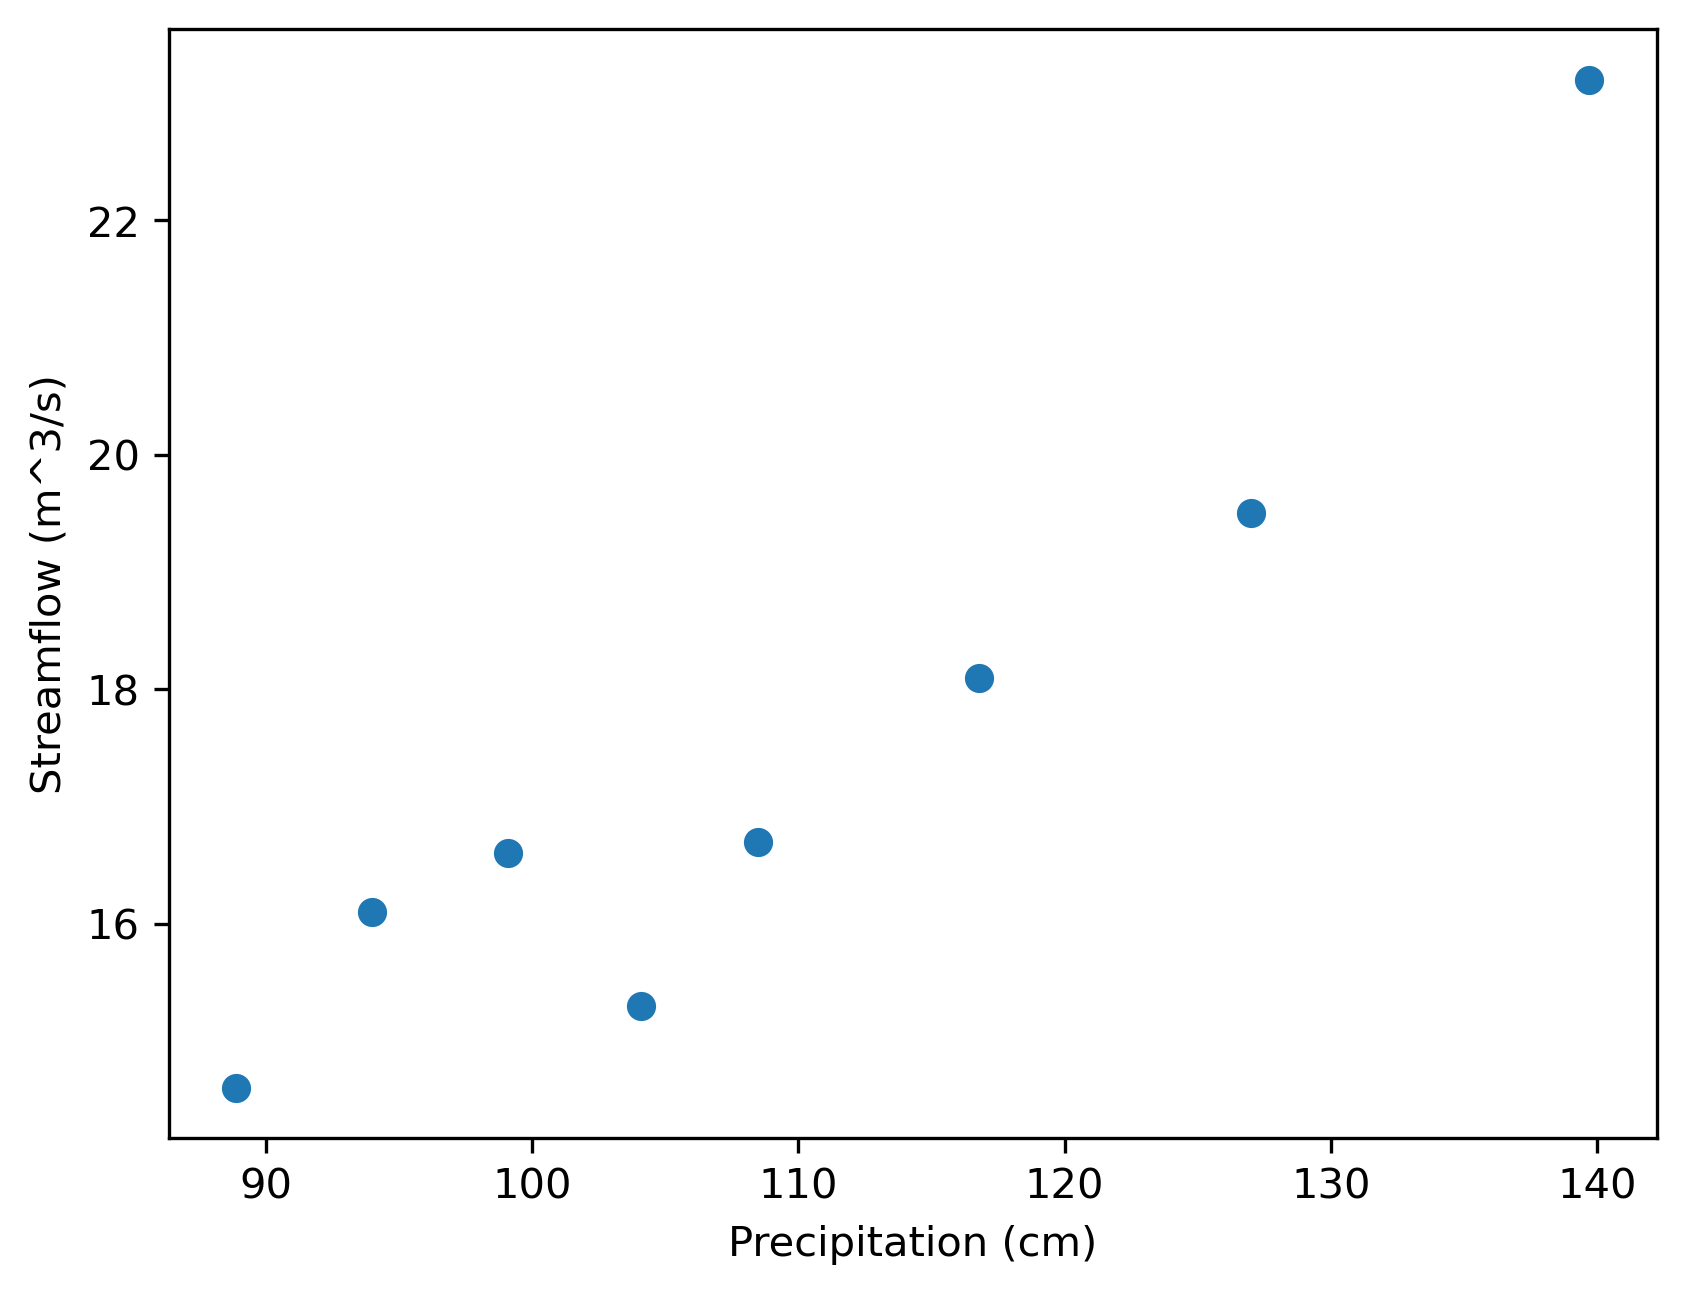

In [2]:
P = np.array([88.9, 108.5, 104.1, 139.7, 127, 94, 116.8, 99.1]) # cm
Q = np.array([14.6, 16.7, 15.3, 23.2, 19.5, 16.1, 18.1, 16.6]) # m^3/s
plt.scatter(P,Q)
plt.xlabel('Precipitation (cm)')
plt.ylabel('Streamflow (m^3/s)')
plt.show()

Find the best-fit line and report $r^2$. Add to plot. Compare to built-in SciPy function.

In [3]:
n = len(P)
a1 = (n * np.sum(P*Q) - np.sum(P)*np.sum(Q)) / (n * np.sum(P**2) - np.sum(P)**2)
a0 = np.mean(Q) - a1 * np.mean(P)
print('Coefficients: ', a0,a1)

St = np.sum((Q - np.mean(Q))**2)
Sr = np.sum((Q - a0 - a1*P)**2)
print('r2 = ', (St - Sr) / St)

Coefficients:  0.8427826132030951 0.15187078817261732
r2 =  0.8939717647335341


In [4]:
from scipy import stats
res = stats.linregress(P,Q)
print('Scipy function:')
print('Slope: ', res.slope)
print('Intercept: ', res.intercept)
print('r2: ', res.rvalue ** 2)

Scipy function:
Slope:  0.1518707881726192
Intercept:  0.842782613202889
r2:  0.8939717647335346


The result matches. Add best-fit line to the scatter plot:

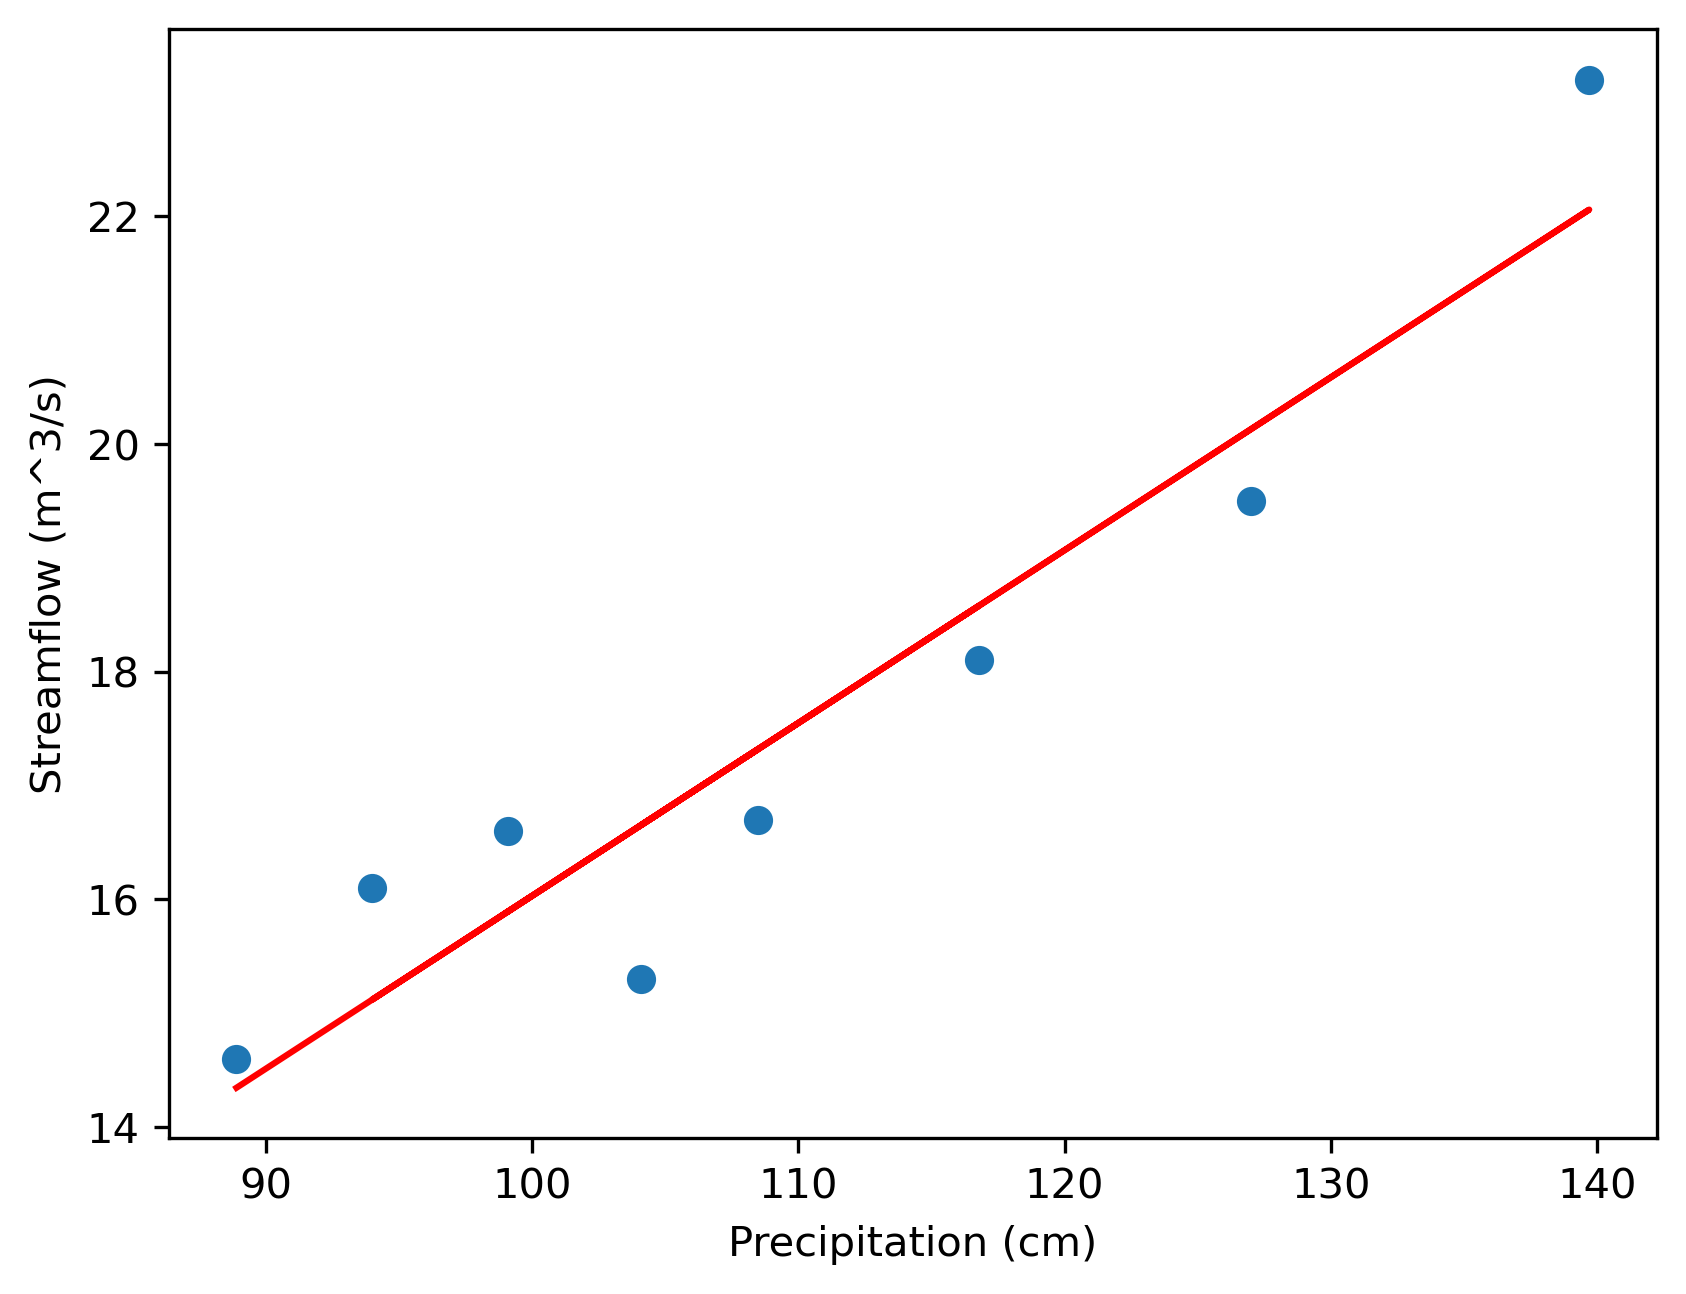

In [5]:
plt.scatter(P,Q)
plt.plot(P, a0 + a1*P, c='red')
plt.xlabel('Precipitation (cm)')
plt.ylabel('Streamflow (m^3/s)')
plt.show()

For the last two questions:
- What is the streamflow if precipitation is 120 cm? 
- If drainage area is 1100 km$^2$, estimate what fraction of precipitation is lost via other processes (evaporation, groundwater infiltration, consumptive use).

In [6]:
print('If P=120 cm, Q ~= ', a0+a1*120, 'm^3/s')

If P=120 cm, Q ~=  19.067277193917175 m^3/s


In [7]:
# total precip volume in km^3
Ptotal = 120 * 10e-5 * 1100
# total streamflow volume in km^3 (multiply by seconds per year)
Qtotal = 19.067277 * 10e-9 * 3.154e7
print(Qtotal/Ptotal)

0.45559236104545453


The streamflow makes up about 45% of the total precipitation volume, so ~55% is lost to other processes.

##### Logistic growth with harvesting - ODE

This problem is adapted from the SIMIODE textbook, Project 3.5.2. Given the logistic growth model with harvesting (from L11):

$$ \frac{dP}{dt} = rP(1-\frac{P}{K}) - hP $$

Along with annual data below for $P$ and $h$ over the period 1978-2007, find the best-fit parameters $r$ and $K$ to minimize the sum of squared residuals. Report $r^2$.

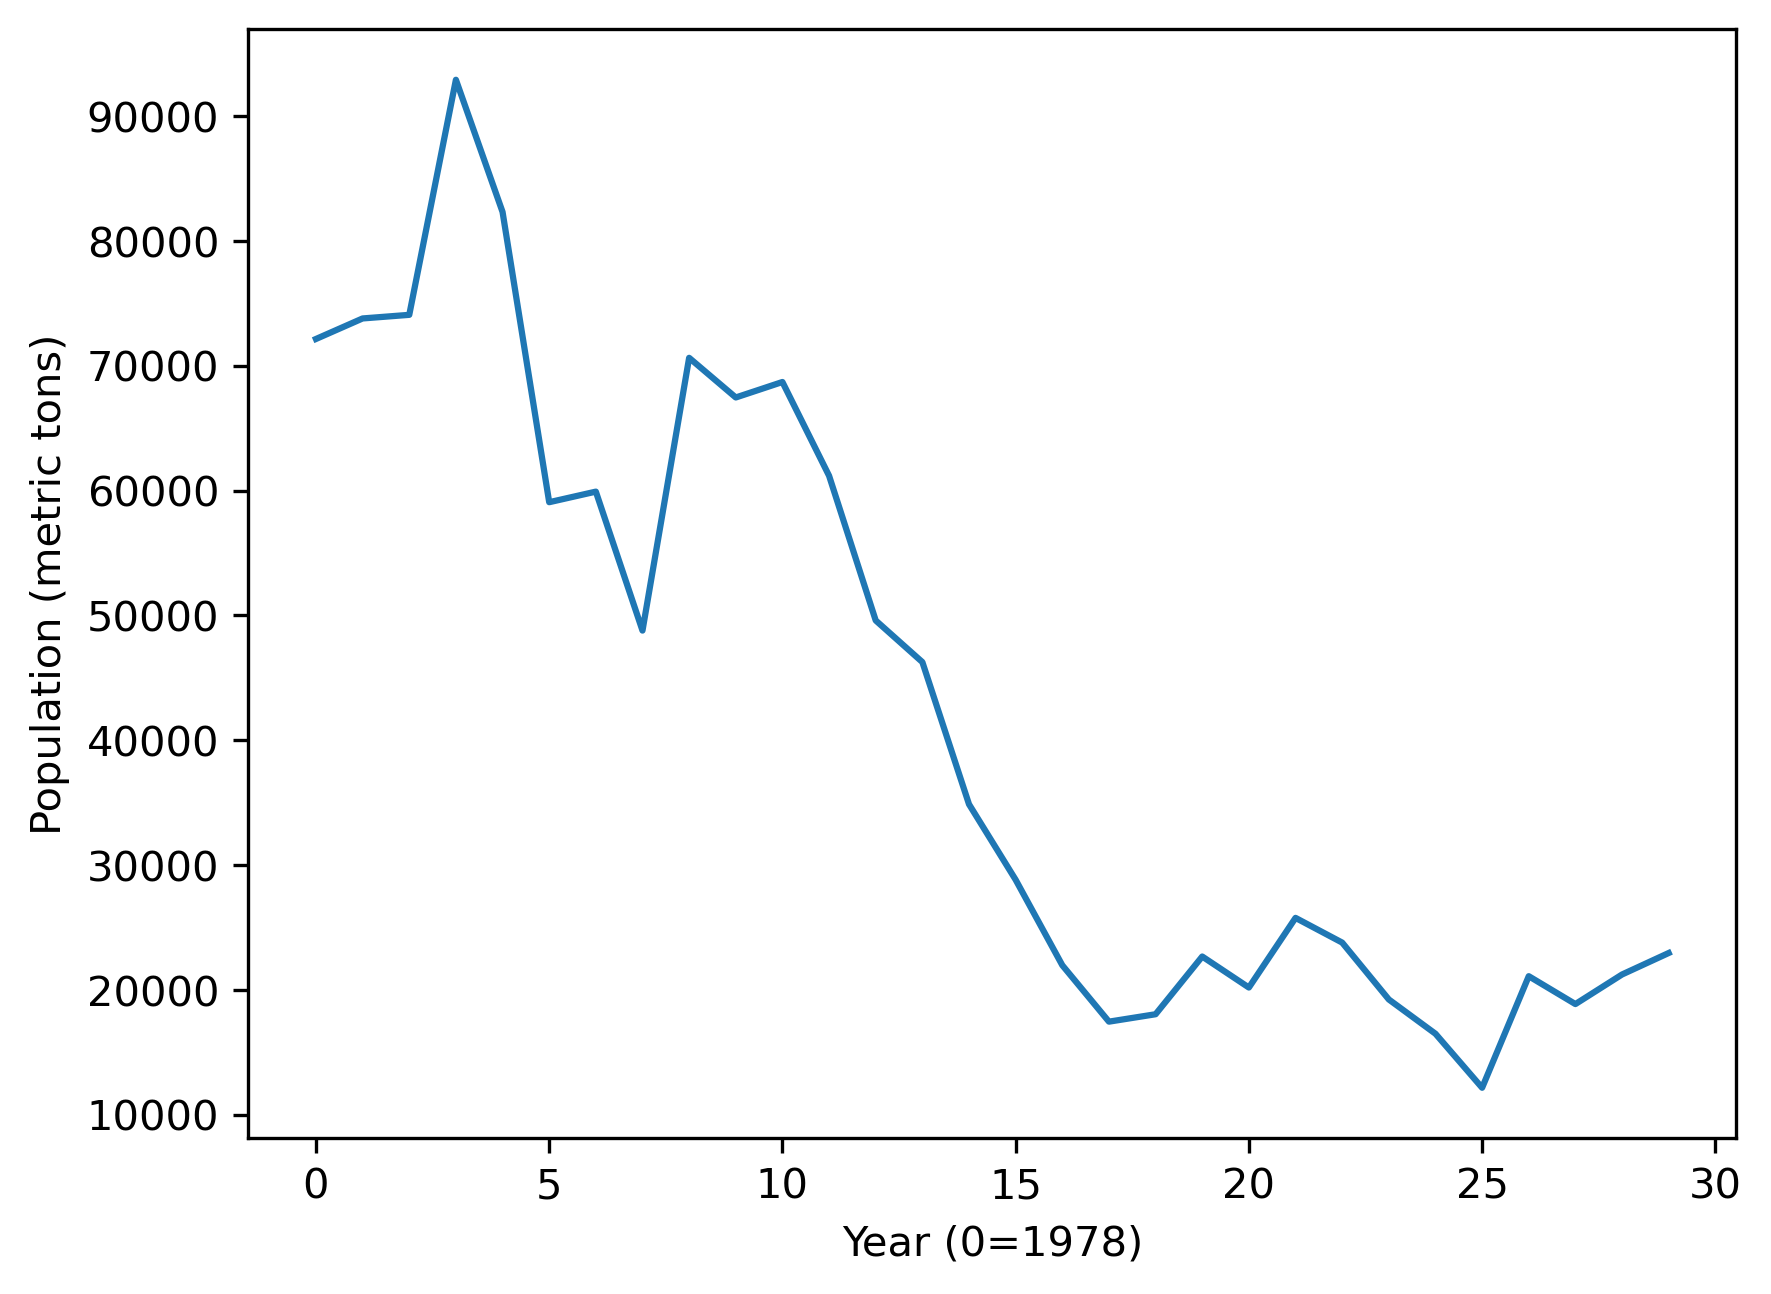

In [8]:
# code
P_data = [72148, 73793, 74082, 92912, 82323, 59073, 59920, 48789, 70638, 67462, 68702, 61191, 49599, 46266, 34877, 28827, 21980, 17463, 18057, 22681, 20196, 25776, 23796, 19240, 16495, 12167, 21104, 18871, 21241, 22962]
h_data = [0.18847, 0.149741, 0.21921, 0.17678, 0.28203, 0.34528, 0.20655, 0.33819, 0.14724, 0.19757, 0.23154, 0.20860, 0.33565, 0.29534, 0.33185, 0.35039, 0.28270, 0.19928, 0.18781, 0.19357, 0.18953, 0.17011, 0.15660, 0.28179, 0.25287, 0.25542, 0.08103, 0.087397, 0.081952, 0.10518]

plt.plot(P_data)
plt.xlabel('Year (0=1978)')
plt.ylabel('Population (metric tons)')
plt.show()

For each candidate parameter set $(r,K)$, we solve with Euler's method using $\Delta t = 1$ year. Use a simplified version of our L11 code, but add an extra argument to both `euler` and the rate function so that the parameters can be passed in.

In [9]:
def f(t,P,params): # rate function f(x,y)
    r, K = params
    return r * P * (1 - P / K) - h_data[t] * P

def euler(f, y0, xmin, xmax, h, params):
    x = np.arange(xmin, xmax+h, h)
    y = np.zeros(len(x)) 
    y[0] = y0           
    for i in range(len(x)-1):
        y[i+1] = y[i] + f(x[i],y[i],params) * h
    return x,y

Note that the derivative function needs to access `h_data[t]` from the table. This will only work if we are using an integer timestep. The same goes for the evaluation of the squared residuals - the ODE solution must be defined at all points in the data table. More accurate solution methods would require us to evaluate fractional timesteps, which would be more challenging.

Do not confuse the step size `h` in Euler's method with the harvesting rate `h_data` in the logistic growth equation, which comes from the data table.

Next set up the residual function: for a given $(r,K)$ combination, we want to run the ODE solution and return the $S_r$. Use the observed `P_data[0]` as the initial condition of the model, and run from $t=0$ to $t=29$ (30 years).

In [10]:
def Sr(x):
    t,P = euler(f, P_data[0], 0, 29, 1, params=x)
    return np.sum((P_data - P) ** 2)

The input vector `x = (r,K)`. We can evaluate $S_r$ for any combination of parameters. To guess values, we know $r \in [0,1]$ by definition. The carrying capacity $K$ is more difficult, but will probably be on the order of the population values in the table, $K \approx 100,000$.

In [11]:
print(Sr([0.2,100000]))

18345674492.361168


Is this a good value of $S_r$? Let's see how it changes with different parameter values, in this case a random sample.

In [12]:
num_samples = 1000
r_test = np.random.rand(num_samples) # between 0-1
K_test = np.random.rand(num_samples) * 1e6 # between 0 - 1e6
Sr_test = np.zeros(num_samples) # to fill in

for i in range(num_samples):
    Sr_test[i] = Sr([r_test[i], K_test[i]])

/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_20051/1377638667.py:3: RuntimeWarning: overflow encountered in scalar multiply
  return r * P * (1 - P / K) - h_data[t] * P
/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_20051/1377638667.py:3: RuntimeWarning: invalid value encountered in scalar subtract
  return r * P * (1 - P / K) - h_data[t] * P
/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_20051/2481221199.py:3: RuntimeWarning: overflow encountered in square
  return np.sum((P_data - P) ** 2)


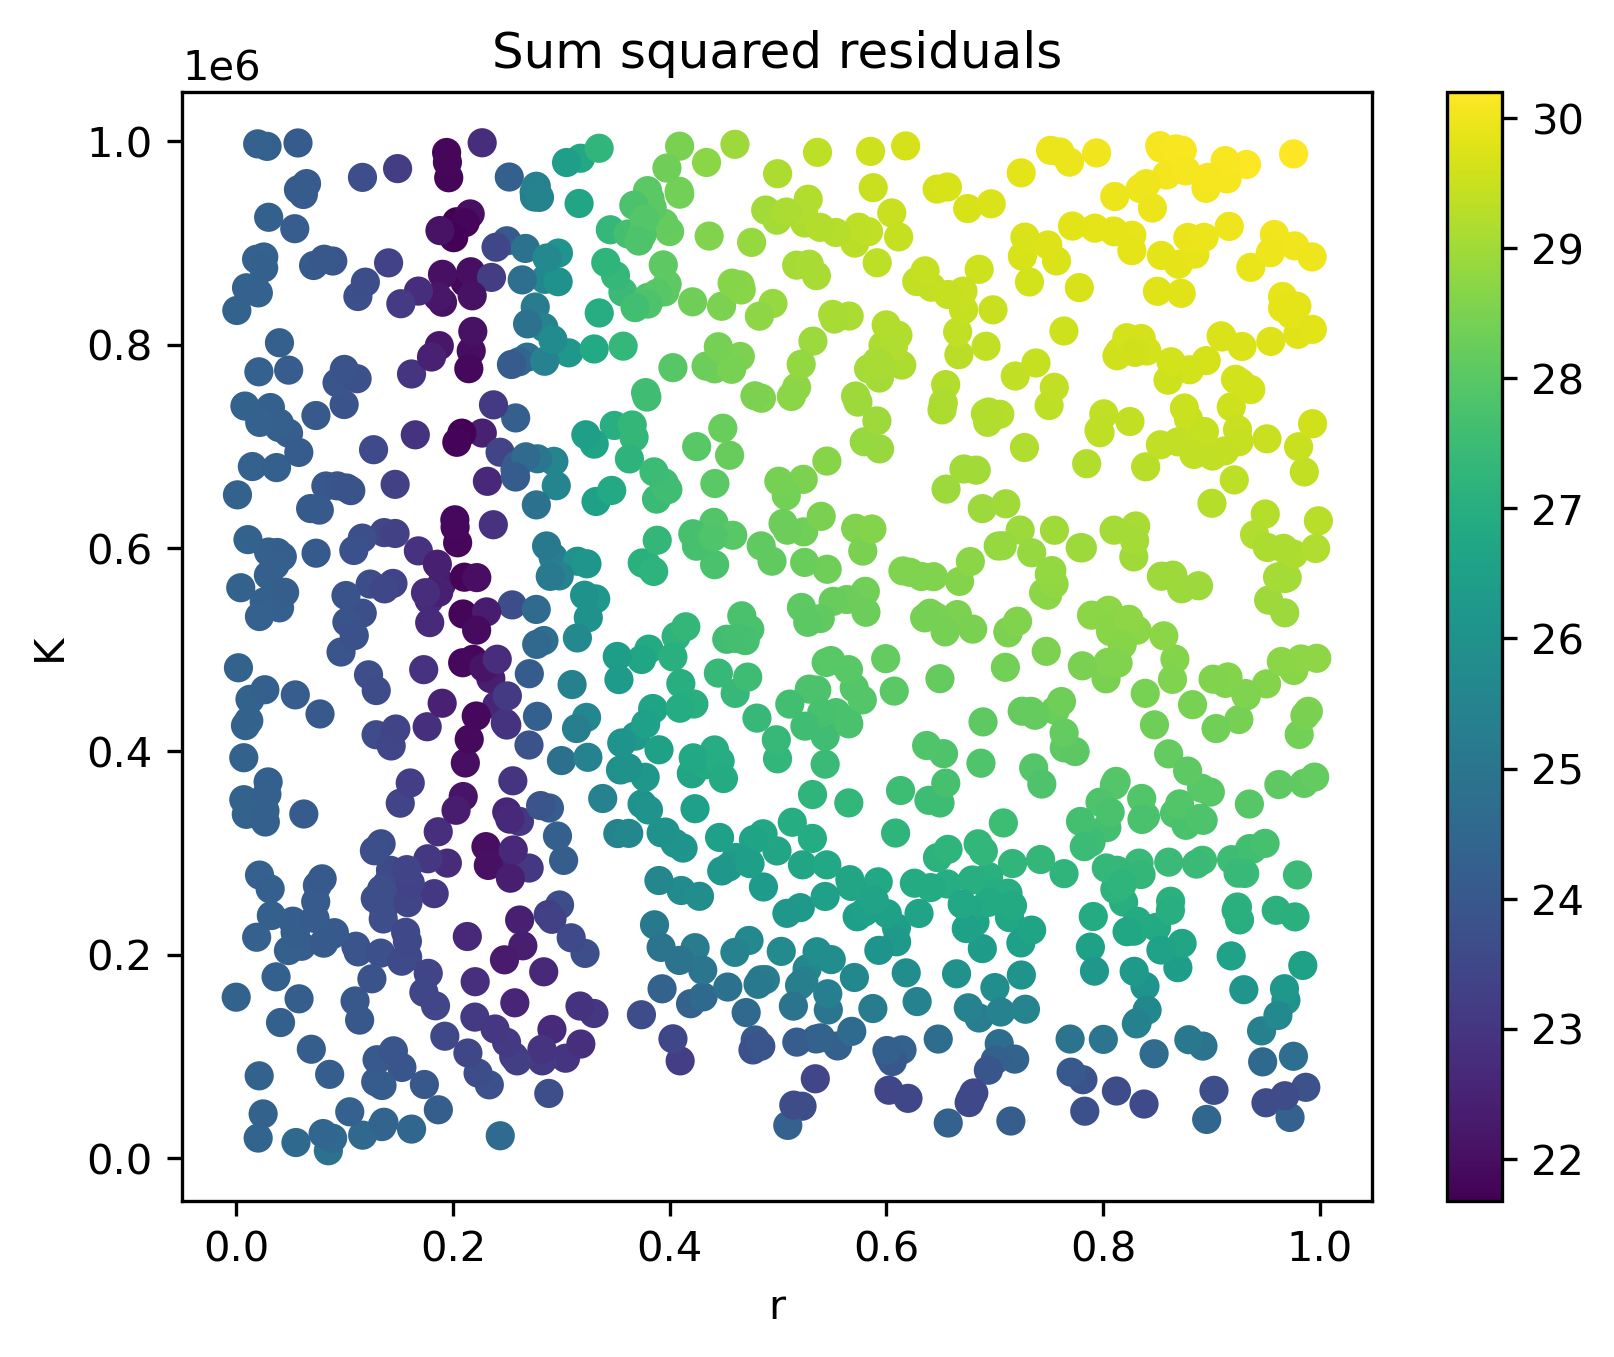

In [13]:
# plot the log of Sr_test to see differences across orders of magnitude
plt.scatter(r_test, K_test, c=np.log(Sr_test))
plt.xlabel('r')
plt.ylabel('K')
plt.title('Sum squared residuals')
plt.colorbar()
plt.show()

Note that some of our $r,K$ combinations produce an overflow warning and return `NaN`, likely because the errors are so large. From this plot it looks like an optimal parameter combination might fall near $r=0.25, K=300,000$. Let's use a gradient-based optimization to find out.

In [14]:
from scipy.optimize import minimize
res = minimize(Sr, x0=[0.25, 300000])
print(res)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2389249227.725023
        x: [ 1.979e-01  2.090e+06]
      nit: 14
      jac: [ 7.133e+08  0.000e+00]
 hess_inv: [[ 1.139e-13 -1.684e-05]
            [-1.684e-05  4.755e+03]]
     nfev: 131
     njev: 40


The result seems reasonable ($r=0.19, K=340,000$). The message about precision loss could be because the parameters are very different orders of magnitude, or because the `Sr` values are so large. Similar to how we plotted the log-transform of `Sr`, it might make sense to optimize `log(Sr)` too.

The scatter plot also brings up the concept of parameter sensitivity: the value of $r$ has a large effect on the error, but if we find the right $r$, the value of $K$ can take a range of values without changing the error too much. We will cover parameter sensitivity in more detail next class.

How does our fitted model look, and what is the $r^2$?

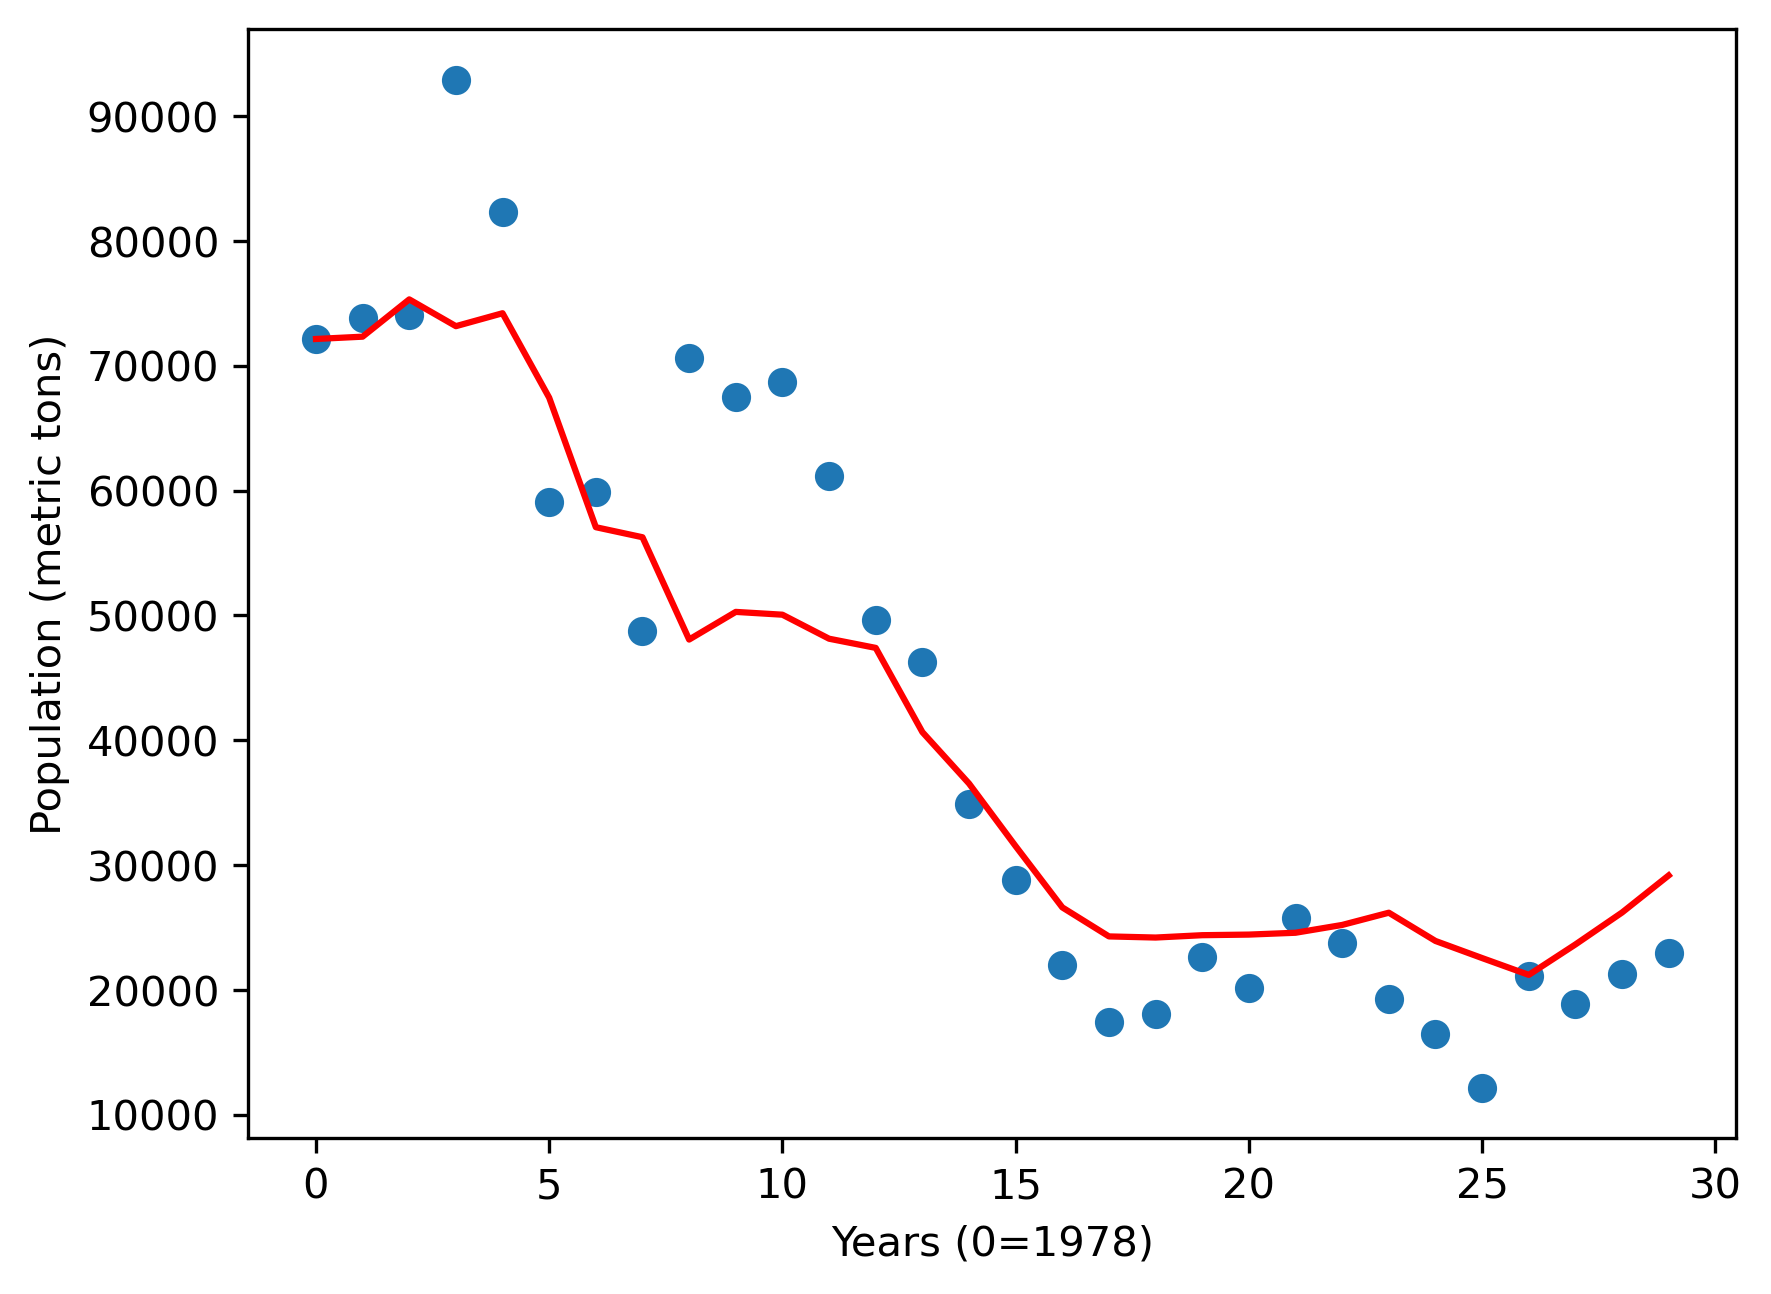

In [15]:
best_x = res.x
t,P = euler(f, P_data[0], 0, 29, 1, params=best_x)
plt.scatter(t, P_data)
plt.plot(t, P, c='red')
plt.xlabel('Years (0=1978)')
plt.ylabel('Population (metric tons)')
plt.show()

The model is not a smooth curve because of the `h_data` values from the table. With a constant `h` this would look more like our L11 code.

In [16]:
best_Sr = res.fun # minimum Sr value from the optimization
St = np.sum((P_data - np.mean(P_data))**2)
print('r2 = ', (St - best_Sr) / St)

r2 =  0.8635739216620052
